The k-modes algorithm uses a simple matching dissimilarity measure
to deal with categorical objects, replaces the means of clusters with modes, and uses a frequency-based method to
update modes in the clustering process to minimize the clustering cost function. With these extensions the k-modes
algorithm enables the clustering of categorical data in a fashion similar to k-means

In [1]:
'''Load Packages'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings
from sklearn.cluster import KMeans 
import random
from sklearn import metrics 
from scipy.spatial.distance import cdist

In [2]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

In [3]:
# function to transform into numerical bins by normal/gaussian distribution
def categorical_transform(col):
    classnames, factorval, rank = np.unique(col, return_inverse = True,return_counts = True)
    
      
    temp = np.sort(rank)
    temp = np.concatenate((temp[::2], temp[1::2][::-1]))
    rank = random.sample(range(1, len(temp)+1),len(temp))
    
    category_count = {}
    for i in range(len(classnames)):
        category_count[classnames[i]] = rank[i]
    
    check_list = list(col)
    for i in range(len(check_list)):
        for key, value in category_count.items():
            if check_list[i] == key:
                factorval[i] = value 
                break
    
    return category_count, factorval

In [4]:
def cat_to_names(df,references):
    ref = df.columns[df.columns.isin(references.keys())].to_list()
    temp_df = df.copy()
    for key in ref:
        vals = references[key]
        for label_key in vals.keys():
            temp_df[key] = temp_df[key].replace(vals[label_key],label_key)
    return temp_df

In [17]:
## load data set
carmax_df = pd.read_csv('C:\\Users\\ttran\\Desktop\\CarMax\\CaseDataRemodeled.csv')
new_df = pd.read_csv('C:\\Users\\ttran\\Desktop\\CarMax\\newdata.csv')

In [18]:
carmax_df['job_assign'] = new_df['job_assign']
carmax_df['customer_income'] = new_df['new_income']
carmax_df['customer_age'] = new_df['new_ages']

In [19]:
cluster_df = carmax_df.copy().drop(['purchase_make','customer_age','customer_previous_purchase','customer_distance_to_dealer',
                             'post_purchase_satisfaction','vehicle_warranty_used',
                             'purchase_price_UB','purchase_class','job_assign','purchase_vehicle_year'], axis=1)

In [20]:
cluster_df.head()

,purchase_model,purchase_price_LB,trade_in,vehicle_financing,customer_income,customer_gender,subsequent_purchases,AgeBin,made_in
0,CHARGER,15001.0,1,1,40001 - 60000,U,1,Twenties,UNITED STATES
1,F150,15001.0,0,0,0 - 20000,F,0,Fifties,UNITED STATES
2,328,25001.0,1,1,60001 - 80000,F,0,Forties,GERMANY
3,GS 300,10001.0,0,1,20001 - 40000,M,0,Twenties,JAPAN
4,CRUZE,15001.0,1,1,120001 - 140000,M,1,Thirties,UNITED STATES


In [21]:
## references of transformation for later 
references = {}

# transform to numerical values 
for i in cluster_df.columns:
    if cluster_df[i].dtype == 'object':
        classes = cluster_df[i]
        references[i], cluster_df[i] = categorical_transform(classes)

In [109]:
cluster_df['purchase_class'] = carmax_df['purchase_class']

In [110]:
sedan = cluster_df[cluster_df.purchase_class=='sedan'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
truck = cluster_df[cluster_df.purchase_class=='truck'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
suv = cluster_df[cluster_df.purchase_class=='suv'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
wagon = cluster_df[cluster_df.purchase_class=='wagon'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
van = cluster_df[cluster_df.purchase_class=='van'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
coupe = cluster_df[cluster_df.purchase_class=='coupe'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
convertible = cluster_df[cluster_df.purchase_class=='convertible'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)

vehicle_classes = [sedan,truck,suv,wagon,van,coupe,convertible]

### Elbow Method to determine k for each cluster of vehicle class

sedan
1 : 2.8675260214164
2 : 2.670157526280855
3 : 2.5195595256059033
4 : 2.407668216359958
5 : 2.341225991673779
6 : 2.258476128147801
7 : 2.20246980119014
8 : 2.1537953663835094
9 : 2.1248689147235442
10 : 2.078435209804276
11 : 2.0425401223832726
12 : 2.009230195808777
13 : 1.9784175409222486
14 : 1.9691517596663588


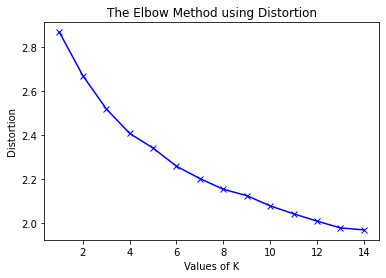

1 : 1359809.9999999893
2 : 1204145.6889484422
3 : 1082187.3258027649
4 : 979421.546302528
5 : 888269.0797160324
6 : 837653.8005647976
7 : 801092.2478692038
8 : 767954.6010782835
9 : 735846.3772642557
10 : 710541.4627840203
11 : 686100.1214994328
12 : 667402.7049879252
13 : 650607.6257170067
14 : 639840.6061861034


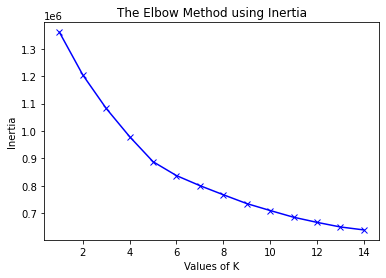

truck
1 : 2.8992466414481073
2 : 2.7036551781044453
3 : 2.5619867643058027
4 : 2.4967899432460587
5 : 2.3997952557891957
6 : 2.3050235548136047
7 : 2.2464986080943454
8 : 2.196066945810026
9 : 2.133847343053192
10 : 2.0862854720041852
11 : 2.0609550729210997
12 : 2.0085431528790405
13 : 1.9819771895027447
14 : 1.9491904860174305


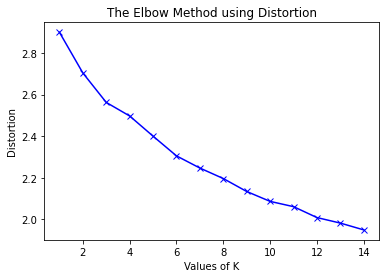

1 : 258903.00000000105
2 : 229019.42255402415
3 : 207799.39370093547
4 : 190476.8238474734
5 : 174295.63743120787
6 : 162248.46073651276
7 : 153537.1044030066
8 : 146679.4065075405
9 : 140544.56464386577
10 : 134904.84060182824
11 : 130664.1894060354
12 : 125925.69514793924
13 : 122216.67612490681
14 : 119266.68147546634


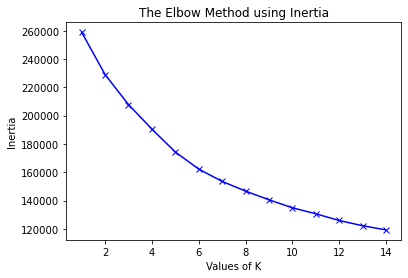

suv
1 : 2.884620032227118
2 : 2.687791282269718
3 : 2.572706060398042
4 : 2.433293923476635
5 : 2.3672515622521058
6 : 2.2957997723576686
7 : 2.235276433764495
8 : 2.18587686248626
9 : 2.145174196711092
10 : 2.1005873236701955
11 : 2.0735938838487837
12 : 2.0342837133833154
13 : 2.016179984437767
14 : 1.9915006108537865


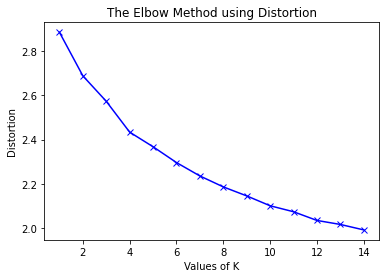

1 : 822330.0000000003
2 : 728137.4875966979
3 : 658903.4543738888
4 : 595520.1152582421
5 : 540434.2947811268
6 : 512017.05252088234
7 : 487992.65013344464
8 : 467295.3286874374
9 : 449844.15191406896
10 : 433581.8848805658
11 : 423172.5442594189
12 : 410411.7030049017
13 : 403751.62185760896
14 : 391602.9594359535


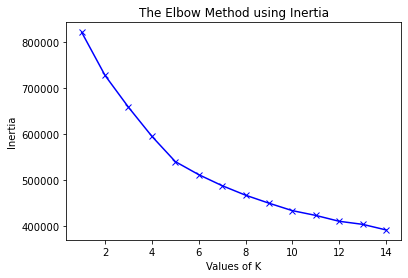

wagon
1 : 2.89246139271278
2 : 2.697012785146708
3 : 2.550393605176417
4 : 2.4817110248706875
5 : 2.389072594257012
6 : 2.3180499818915874
7 : 2.262641391651409
8 : 2.228568294722314
9 : 2.1859747800097016
10 : 2.144767797976123
11 : 2.1111854744901946
12 : 2.0811998937102194
13 : 2.057491070790264
14 : 2.0313652732892993


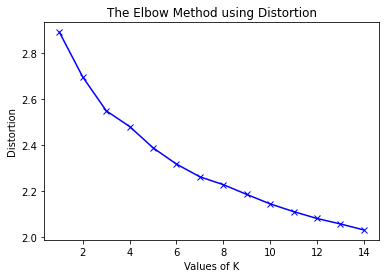

1 : 248408.9999999994
2 : 219911.2938583223
3 : 198346.12416346016
4 : 181038.03567266016
5 : 167921.46365784114
6 : 158497.14016357716
7 : 152001.26965519125
8 : 146339.8900432347
9 : 141063.1967701856
10 : 136789.1666927848
11 : 132816.08161208656
12 : 128640.47578121586
13 : 125249.3060662564
14 : 122452.14542530064


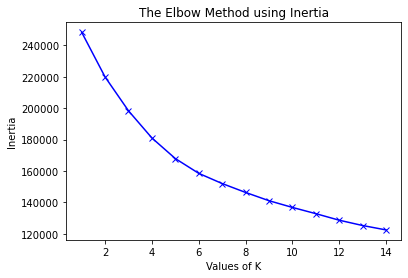

van
1 : 2.8867102894896615
2 : 2.690124618775577
3 : 2.544523807275813
4 : 2.47548646091572
5 : 2.3826863432104193
6 : 2.3101542061878275
7 : 2.2592562594424486
8 : 2.191250361228792
9 : 2.154766920998292
10 : 2.1065629251947833
11 : 2.0692623436948177
12 : 2.0243477694700216
13 : 1.9951082751279228
14 : 1.9642624883003323


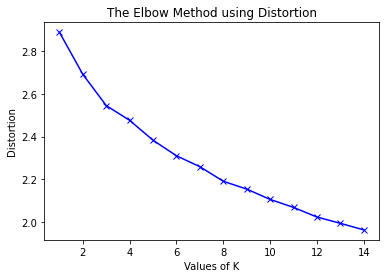

1 : 127169.9999999993
2 : 112631.04770532303
3 : 102162.94478572436
4 : 93288.86840804685
5 : 84743.99213713243
6 : 80125.34770574654
7 : 76217.09146244393
8 : 72528.36652286733
9 : 69499.34716168059
10 : 66494.44922731831
11 : 64526.75200699859
12 : 62152.43670167162
13 : 60617.74568816645
14 : 59010.90158313017


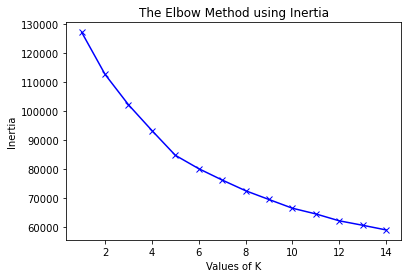

coupe
1 : 2.8471067292442007
2 : 2.6134258356287434
3 : 2.457045858781083
4 : 2.3054503986168142
5 : 2.2394840669858564
6 : 2.1714869957372076
7 : 2.1000017240051436
8 : 2.058656509968307
9 : 2.0031544037721356
10 : 1.9836001185428065
11 : 1.9379375713523062
12 : 1.9100342458456796
13 : 1.875708880871375
14 : 1.8366234713410754


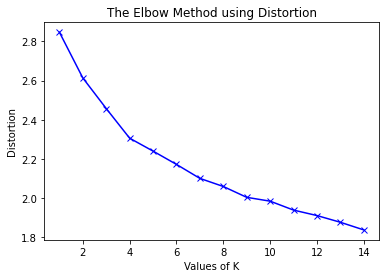

1 : 220770.00000000006
2 : 186434.82461349244
3 : 167160.0491024221
4 : 152007.38320786168
5 : 137509.22219834715
6 : 128000.18071753591
7 : 121555.86725082988
8 : 116223.26190559627
9 : 111451.06265147196
10 : 107141.71292989969
11 : 103368.33760651115
12 : 100306.4255040294
13 : 97371.17902193092
14 : 94342.39738854178


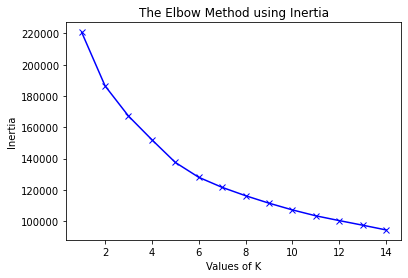

convertible
1 : 2.8930818185195206
2 : 2.6499567243216813
3 : 2.514985646274832
4 : 2.4476483356106375
5 : 2.324789321187634
6 : 2.2615290512374138
7 : 2.197594884731487
8 : 2.1477206848018326
9 : 2.0992257517641058
10 : 2.0590058901521844
11 : 2.0210661467362017
12 : 1.9957794644248783
13 : 1.9701759759942186
14 : 1.9286052752012914


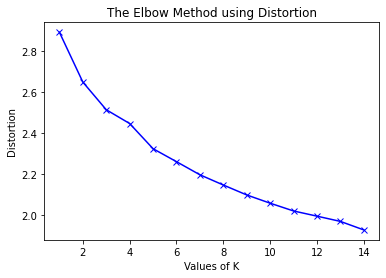

1 : 165474.00000000012
2 : 140262.32693411387
3 : 128009.70873502461
4 : 116702.67690823598
5 : 107416.25396308233
6 : 101000.40817637429
7 : 95851.34051132783
8 : 91621.98440752192
9 : 88295.15673862258
10 : 85223.92722779751
11 : 82410.62698674577
12 : 79943.27601744163
13 : 77538.19174436867
14 : 74955.30595888884


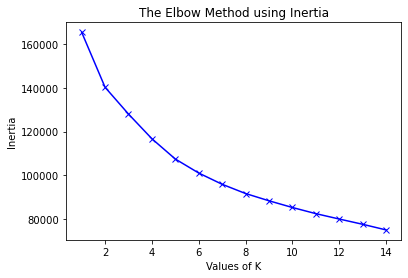

In [111]:
vehicle_classes_name = ['sedan','truck','suv','wagon','van','coupe','convertible']
index = 0

for group in vehicle_classes:
    
    distortions = [] 
    inertias = []
    mapping1 = {}
    mapping2 = {} 
    K = range(1,15) 

    X = group.values[:,:]
    X = np.nan_to_num(X)
    cluster_dataset = StandardScaler().fit_transform(X)
    cluster_dataset
    
    for k in K: 

        #Building and fitting the model 
        kmeanModel = KMeans(init="k-means++", n_clusters=k, n_init=50)
        kmeanModel.fit(cluster_dataset)     
      
        distortions.append(sum(np.min(cdist(cluster_dataset, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / cluster_dataset.shape[0]) 
        inertias.append(kmeanModel.inertia_) 
  
        mapping1[k] = sum(np.min(cdist(cluster_dataset, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / cluster_dataset.shape[0] 
        mapping2[k] = kmeanModel.inertia_ 
    
    print(vehicle_classes_name[index])
    index += 1
    
    for key,val in mapping1.items(): 
        print(str(key)+' : '+str(val)) 
        
    plt.plot(K, distortions, 'bx-') 
    plt.xlabel('Values of K') 
    plt.ylabel('Distortion') 
    plt.title('The Elbow Method using Distortion') 
    plt.show() 
    
    for key,val in mapping2.items(): 
        print(str(key)+' : '+str(val)) 
    
    plt.plot(K, inertias, 'bx-') 
    plt.xlabel('Values of K') 
    plt.ylabel('Inertia') 
    plt.title('The Elbow Method using Inertia') 
    plt.show()    

In [112]:
from sklearn.preprocessing import StandardScaler

## k_values = [7,6,6,6,8,6,7]
k_values = 10
#k_values = [7,6,6,6,8,6,7]

index = 0

for group in vehicle_classes:
    X = group.values[:,:]
    X = np.nan_to_num(X)
    cluster_dataset = StandardScaler().fit_transform(X)
    cluster_dataset

    num_clusters = 6
    index += 1

    k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=50,algorithm = "elkan",random_state = 2013)
    k_means.fit(cluster_dataset)
    labels = k_means.labels_
    group["cluster_label"] = labels

In [113]:
sedanCluster = cluster_with_names = cat_to_names(sedan,references)
truckCluster = cluster_with_names = cat_to_names(truck,references)
suvCluster = cluster_with_names = cat_to_names(suv,references)
wagonCluster = cluster_with_names = cat_to_names(wagon,references)
vanCluster = cluster_with_names = cat_to_names(van,references)
coupeCluster = cluster_with_names = cat_to_names(coupe,references)
convertibleCluster = cluster_with_names = cat_to_names(convertible,references)

## SUV

In [114]:
np.sort(suvCluster.cluster_label.unique())

array([0, 1, 2, 3, 4, 5])

### Purchase Make

In [22]:
test = suvCluster.groupby(['cluster_label','purchase_model']).count().reset_index()
test = test.sort_values(by=['cluster_label','purchase_price_LB'],ascending=[True,False])
test = test.groupby('cluster_label').head(10)[['cluster_label','purchase_model','purchase_price_LB']]
test.pivot(index = 'purchase_model',columns='cluster_label',values='purchase_price_LB').fillna(0).style.highlight_max(color = 'green').format(int)

NameError: name 'suvCluster' is not defined

### Purchase Model

In [123]:
test = suvCluster.groupby(['cluster_label','purchase_model']).count().reset_index()
test = test.sort_values(by=['cluster_label','purchase_price_LB'],ascending=[True,False])
test = test.groupby('cluster_label').head(10)[['cluster_label','purchase_model','purchase_price_LB']]
test.pivot(index = 'purchase_model',columns='cluster_label',values='purchase_price_LB').fillna(0).style.highlight_max(color = 'green').format(int)

cluster_label,0,1,2,3,4,5
purchase_model,,,,,,
4RUNNER,0,0,0,0,493,0
CAYENNE,273,0,0,0,0,0
CR-V,0,105,1099,689,994,591
EDGE,0,110,1153,845,863,791
EQUINOX,0,66,846,466,0,450
ESCAPE,0,163,1571,942,1326,844
EXPLORER,0,73,764,480,518,0
GL450,329,0,0,0,0,0
GLK350,630,0,0,0,0,0


### Customer Income

In [79]:
test = suvCluster.groupby(['cluster_label','customer_income']).count().reset_index()
test = test.sort_values(by=['cluster_label','purchase_make'],ascending=[True,False])
test = test.groupby(['cluster_label','customer_income']).head(1)
test.pivot(index = 'customer_income',columns='cluster_label',values='purchase_make').fillna(0).style.highlight_max(color = 'green').format(int)

cluster_label,0,1,2,3,4,5
customer_income,,,,,,
0 - 20000,259,834,1543,3246,1682,1989
100001 - 120000,162,532,1516,943,786,1571
120001 - 140000,89,174,785,457,329,799
140001 - 160000,65,149,870,480,277,904
160001 - 180000,30,67,473,234,124,456
180001 - 200000,18,37,176,96,53,197
200001 - 1000001,15,65,10,339,37,6
200001+,105,186,1316,404,382,1188
20001 - 40000,547,4799,2236,3420,4769,3239


### Made_In

In [102]:
test = suvCluster.groupby(['cluster_label','made_in']).count().reset_index()
test = test.sort_values(by=['cluster_label','purchase_make'],ascending=[True,False])
test.pivot(index = 'made_in',columns='cluster_label',values='purchase_make').fillna(0).style.highlight_max(color = 'green').format(int)

cluster_label,0,1,2,3,4,5,6,7,8,9
made_in,,,,,,,,,,
GERMANY,4142,123,150,0,152,233,147,287,241,243
JAPAN,1559,5218,4247,918,8480,4199,1007,4360,1339,4754
SOUTH KOREA,0,779,783,254,1393,581,138,649,23,810
SWEDEN,594,0,0,0,0,0,19,4,0,1
UNITED KINGDOM,0,39,37,0,65,78,30,68,716,48
UNITED STATES,0,4829,3251,9439,4656,4463,1190,4685,3526,6423


### Customer_Gender

In [101]:
test = suvCluster.groupby(['cluster_label','customer_gender']).count().reset_index()
test.pivot(index = 'customer_gender',columns='cluster_label',values='purchase_make').fillna(0).style.highlight_max(color = 'green').format(int)

cluster_label,0,1,2,3,4,5,6,7,8,9
customer_gender,,,,,,,,,,
F,2291,0,8468,4431,8516,3897,1161,3929,1176,5214
M,3286,7554,0,5740,6230,4934,1138,5056,4062,5661
U,718,3434,0,440,0,723,232,1068,607,1404


### Trade_In

In [83]:
test = suvCluster.groupby(['cluster_label','trade_in']).count().reset_index()
test = test.sort_values(by=['cluster_label','purchase_make'],ascending=[True,False])
test.pivot(index = 'trade_in',columns='cluster_label',values='purchase_make').fillna(0).style.highlight_max(color = 'green').format(int)

cluster_label,0,1,2,3,4,5
trade_in,,,,,,
0,1218,7111,7008,8029,11307,7855
1,1358,7138,11520,9321,5453,14052


### Finance

In [84]:
test = suvCluster.groupby(['cluster_label','vehicle_financing']).count().reset_index()
test = test.sort_values(by=['cluster_label','purchase_make'],ascending=[True,False])
test.pivot(index = 'vehicle_financing',columns='cluster_label',values='purchase_make').fillna(0).style.highlight_max(color = 'green').format(int)

cluster_label,0,1,2,3,4,5
vehicle_financing,,,,,,
0,639,2708,0,17350,1589,0
1,1937,11541,18528,0,15171,21907


### Age

In [100]:
test = suvCluster.groupby(['cluster_label','AgeBin']).count().reset_index()
test = test.sort_values(by=['cluster_label','purchase_make'],ascending=[True,False])
test.pivot(index = 'AgeBin',columns='cluster_label',values='purchase_make').fillna(0).style.highlight_max(color = 'green').format(int)

cluster_label,0,1,2,3,4,5,6,7,8,9
AgeBin,,,,,,,,,,
Eighties,13,39,27,39,57,147,10,96,12,0
Fifties,1132,2097,1871,2139,3123,1749,434,1947,954,0
Forties,2072,3419,2747,3242,4745,2263,642,2579,1953,0
HundredPlus,31,5,0,16,0,86,19,46,26,135
Nineties,4,1,2,4,2,9,2,5,1,0
Seventies,89,41,63,200,54,494,55,334,85,700
Sixties,438,951,837,967,1459,1254,199,1083,417,65
Thirties,1925,4417,2914,3693,5273,2090,713,2092,2067,0
Twenties,525,0,0,286,0,1342,439,1655,288,11010


In [54]:
test = suvCluster.groupby(['Labels','purchase_model']).count().reset_index()
test = test.sort_values(by=['Labels','purchase_make'],ascending=[True,False])
test = test.groupby('Labels').head(10)[['Labels','purchase_model','purchase_make']]
test = test[test.purchase_make>1000]
test.pivot(index = 'purchase_model',columns='Labels',values='purchase_make').fillna(0).style.highlight_max(color = 'green').format(int)

Labels,0,4,5
purchase_model,,,
CR-V,0,1460,0
EDGE,0,0,2122
ESCAPE,1055,0,2389
JOURNEY,0,0,1062
MURANO,0,1023,0
RAV4,0,1906,0
ROGUE,0,2360,0


In [104]:
suvCluster.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,purchase_price_LB,trade_in,vehicle_financing,customer_income,customer_gender,subsequent_purchases,AgeBin,made_in
cluster_label,,,,,,,,,,
0,MERCEDES-BENZ,X5,30001.0,1,1,40001 - 60000,M,0,Forties,GERMANY
1,NISSAN,ROGUE,15001.0,0,1,40001 - 60000,M,0,Thirties,JAPAN
2,NISSAN,ROGUE,15001.0,0,1,20001 - 40000,F,0,Thirties,JAPAN
3,FORD,ESCAPE,15001.0,1,1,40001 - 60000,M,0,Thirties,UNITED STATES
4,NISSAN,ROGUE,15001.0,1,1,40001 - 60000,F,0,Thirties,JAPAN
5,FORD,ESCAPE,15001.0,1,0,40001 - 60000,M,0,Forties,UNITED STATES
6,FORD,ESCAPE,15001.0,1,1,40001 - 60000,F,4,Thirties,UNITED STATES
7,FORD,ESCAPE,15001.0,0,0,20001 - 40000,M,0,Forties,UNITED STATES
8,CHEVROLET,TAHOE,35001.0,1,1,200001+,M,0,Thirties,UNITED STATES


In [105]:
sedanCluster.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,purchase_price_LB,trade_in,vehicle_financing,customer_income,customer_gender,subsequent_purchases,AgeBin,made_in
cluster_label,,,,,,,,,,
0,BMW,M3,30001.0,1,1,200001+,M,0,Forties,GERMANY
1,CHEVROLET,MALIBU,10001.0,0,1,20001 - 40000,M,0,Twenties,UNITED STATES
2,NISSAN,ALTIMA,10001.0,0,1,20001 - 40000,U,0,Twenties,JAPAN
3,TOYOTA,ALTIMA,15001.0,0,1,40001 - 60000,F,0,Thirties,JAPAN
4,BMW,328,20001.0,0,1,40001 - 60000,M,0,Thirties,GERMANY
5,NISSAN,ALTIMA,10001.0,0,0,20001 - 40000,M,0,Twenties,JAPAN
6,CHEVROLET,MALIBU,10001.0,1,1,20001 - 40000,M,0,Twenties,UNITED STATES
7,NISSAN,ALTIMA,10001.0,0,1,20001 - 40000,M,0,Twenties,JAPAN
8,NISSAN,ALTIMA,10001.0,0,1,20001 - 40000,M,4,Twenties,JAPAN


In [20]:
truckCluster.groupby('Labels').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,job_assign
Labels,,,,,,,,,,,
0,CHEVROLET,SILVERADO 1500,2011,20001.0,0,1,40001 - 60000,M,Forties,UNITED STATES,General Internal Medicine Physicians
1,FORD,F150,2010,15001.0,0,0,?,M,Forties,UNITED STATES,General Internal Medicine Physicians
2,FORD,RAM 1500,2008,15001.0,0,1,40001 - 60000,M,Forties,UNITED STATES,General Internal Medicine Physicians
3,FORD,F150,2012,25001.0,1,1,60001 - 80000,M,Forties,UNITED STATES,"Physicians, All Other; and Ophthalmologists, E..."
4,TOYOTA,TACOMA,2007,15001.0,0,1,40001 - 60000,M,Forties,JAPAN,"Physicians, All Other; and Ophthalmologists, E..."


In [21]:
sorted(references['purchase_model'].items(), key=lambda x: x[1])

[('C350', 1),
 ('MONTANA', 2),
 ('300', 3),
 ('5-Sep', 4),
 ('SUNFIRE', 5),
 ('GALANT', 6),
 ('CC', 7),
 ('ALTIMA', 8),
 ('X6 HYBRID', 9),
 ('VERSA NOTE', 10),
 ('LUCERNE', 11),
 ('300M', 12),
 ('ACCORD', 13),
 ('L300', 14),
 ('STS', 15),
 ('i-280', 16),
 ('E55 AMG', 17),
 ('S55 AMG', 18),
 ('BONNEVILLE', 19),
 ('TAHOE', 20),
 ('M5', 21),
 ('G500', 22),
 ('CLS550', 23),
 ('CL550', 24),
 ('ESCALADE HYBRID', 25),
 ('VUE HYBRID', 26),
 ('RODEO', 27),
 ('CADENZA', 28),
 ('C/V', 29),
 ('NV 2500', 30),
 ('NAVIGATOR', 31),
 ('SILVERADO 3500', 32),
 ('E320', 33),
 ('C320', 34),
 ('SLK55 AMG', 35),
 ('VERONA', 36),
 ('SUBURBAN 1500', 37),
 ('IMPALA', 38),
 ('SEDONA', 39),
 ('SL55 AMG', 40),
 ('CONTINENTAL GT', 41),
 ('XK8', 42),
 ('VENZA', 43),
 ('NAVIGATOR L', 44),
 ('C70', 45),
 ('HIGHLANDER HYBRID', 46),
 ('G25', 47),
 ('ECLIPSE', 48),
 ('E350', 49),
 ('9-2X', 50),
 ('AVALON', 51),
 ('MALIBU CLASSIC', 52),
 ('Z4', 53),
 ('MONTE CARLO', 54),
 ('OUTBACK', 55),
 ('SLK250', 56),
 ('COOPER', 57),

In [22]:
references['purchase_model']

{'128': 339,
 '135': 510,
 '1M': 279,
 '200': 525,
 '3-Sep': 162,
 '300': 3,
 '300 C SRT': 144,
 '300M': 12,
 '300ZX': 208,
 '320': 67,
 '325': 462,
 '328': 529,
 '330': 295,
 '335': 143,
 '335 HYBRID': 615,
 '350Z': 491,
 '370Z': 71,
 '4RUNNER': 422,
 '5-Sep': 4,
 '500': 240,
 '525': 548,
 '528': 239,
 '530': 534,
 '535': 220,
 '540': 590,
 '545': 178,
 '550': 377,
 '626': 205,
 '640': 369,
 '640 B640': 288,
 '645': 187,
 '650': 175,
 '740': 226,
 '745': 470,
 '750': 300,
 '750 HYBRID': 118,
 '760': 585,
 '9-2X': 50,
 '911': 451,
 'A3': 194,
 'A4': 262,
 'A5': 392,
 'A6': 530,
 'A7': 156,
 'A8': 526,
 'ACADIA': 338,
 'ACCENT': 391,
 'ACCORD': 13,
 'ACCORD CROSSTOUR': 160,
 'ACCORD HYBRID': 59,
 'AERIO': 274,
 'ALERO': 227,
 'ALLROAD': 584,
 'ALPINA B7': 304,
 'ALTIMA': 8,
 'ALTIMA HYBRID': 100,
 'AMANTI': 177,
 'ARMADA': 312,
 'ASCENDER': 591,
 'ASCENDER EXT': 92,
 'ASPEN': 428,
 'ASPEN HYBRID': 275,
 'ASTRA': 498,
 'ASTRO': 244,
 'ATS': 133,
 'AURA': 405,
 'AURA HYBRID': 374,
 'AUROR

In [23]:
export_groups = [sedanCluster,truckCluster,suvCluster,wagonCluster,vanCluster,coupeCluster,convertibleCluster]

In [24]:
cluster_names = ['sedanCluster','truckCluster','suvCluster','wagonCluster','vanCluster','coupeCluster'
                        ,'convertibleCluster']
index = 0
for group in export_groups:
    for x in group.Labels.unique():
        group[group.Labels==x].to_csv(cluster_names[index]+str(x)+'.csv', index = False)
    index += 1

In [126]:
k_means.predict([1,2,3,4,5,6,7,8,9,10])

ValueError: Expected 2D array, got 1D array instead:
array=[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [127]:
k_means.cluster_centers_

array([[ 8.32967925e-01,  1.54641651e+00,  4.63015540e-01,
        -4.73507145e-02,  4.85574133e-01, -3.28632288e-01,
        -1.10043503e-01,  5.08180148e-02, -9.63972275e-01],
       [ 1.24887560e+00, -2.86310729e-01, -1.39738273e-01,
         3.80524385e-02, -1.08504085e-01,  5.04392910e-01,
        -1.53202352e-01,  3.21461344e-02, -1.28178876e+00],
       [-4.89268082e-01, -2.33631286e-01,  1.02612154e+00,
         5.81495337e-01, -1.02155494e-01, -1.74140723e-02,
        -1.13897330e-01, -4.65140768e-02,  5.38012063e-01],
       [-4.18654205e-01, -1.90752735e-01, -1.64047884e-01,
        -1.71970425e+00, -2.22658340e-02, -1.19922018e-01,
        -1.10794075e-01,  1.95825314e-02,  4.81723030e-01],
       [-5.54748283e-01, -3.44088034e-01, -9.74543426e-01,
         5.81495337e-01, -1.00138321e-01, -4.25861137e-02,
        -1.85336754e-01, -1.89934042e-02,  5.75371036e-01],
       [-8.69403366e-02, -8.83123409e-02, -5.80594750e-02,
        -2.85692700e-02,  2.58555430e-02, -4.171038

In [131]:
k_means.predict([[ 2, 2, -1.39738273e-01,
         3.80524385e-02, -1.08504085e-01,  5.04392910e-01,
        -1.53202352e-01,  3.21461344e-02, -1.28178876e+00]])

array([0])

In [24]:
carmax_df.corr()

,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases
purchase_vehicle_year,1.000000,0.334743,0.334743,0.086707,-0.036105,0.038663,0.002694,-0.189000,-0.002758
purchase_price_LB,0.334743,1.000000,1.000000,0.171887,-0.081659,0.111430,0.008244,-0.050777,0.003927
purchase_price_UB,0.334743,1.000000,1.000000,0.171887,-0.081659,0.111430,0.008244,-0.050777,0.003927
trade_in,0.086707,0.171887,0.171887,1.000000,0.026117,0.153416,-0.004374,0.021298,0.019382
vehicle_financing,-0.036105,-0.081659,-0.081659,0.026117,1.000000,-0.006877,-0.008675,0.031015,-0.012854
customer_previous_purchase,0.038663,0.111430,0.111430,0.153416,-0.006877,1.000000,-0.009844,0.000548,0.022069
customer_distance_to_dealer,0.002694,0.008244,0.008244,-0.004374,-0.008675,-0.009844,1.000000,-0.012092,-0.001478
vehicle_warranty_used,-0.189000,-0.050777,-0.050777,0.021298,0.031015,0.000548,-0.012092,1.000000,0.013853
subsequent_purchases,-0.002758,0.003927,0.003927,0.019382,-0.012854,0.022069,-0.001478,0.013853,1.000000
